# Subgraph as state graph sample

In [1]:
var userHomeDir = System.getProperty("user.home");
var localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
var langchain4jVersion = "1.9.1";
var langchain4jbeta = "1.9.1-beta17";
var langgraph4jVersion = "1.8-SNAPSHOT";

In [2]:
%%bash 
rm -rf \{userHomeDir}/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j

In [3]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos
%dependency /add org.slf4j:slf4j-jdk14:2.0.9
%dependency /add org.bsc.langgraph4j:langgraph4j-core:\{langgraph4jVersion}
%dependency /add org.bsc.langgraph4j:langgraph4j-langchain4j:\{langgraph4jVersion}
%dependency /add dev.langchain4j:langchain4j:\{langchain4jVersion}
%dependency /add dev.langchain4j:langchain4j-open-ai:\{langchain4jVersion}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.8

%dependency /resolve

Repository local url: file:///Users/bsorrentino/.m2/repository/ added.
Adding dependency org.slf4j:slf4j-jdk14:2.0.9
Adding dependency org.bsc.langgraph4j:langgraph4j-core:1.7-SNAPSHOT
Adding dependency org.bsc.langgraph4j:langgraph4j-langchain4j:1.7-SNAPSHOT
Adding dependency dev.langchain4j:langchain4j:1.9.1
Adding dependency dev.langchain4j:langchain4j-open-ai:1.9.1
Adding dependency net.sourceforge.plantuml:plantuml-mit:1.2024.8
Solving dependencies
Resolved artifacts count: 17
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-jdk14/2.0.9/slf4j-jdk14-2.0.9.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-api/2.0.9/slf4j-api-2.0.9.jar
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j/langgraph4j-core/1.7-SNAPSHOT/langgraph4j-core-1.7-SNAPSHOT.jar
Add to classpath: /Users/bsorrentino/Library/Jupyte

**utility to render graph respresentation in PlantUML**

In [4]:
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;
import org.bsc.langgraph4j.GraphRepresentation;

void displayDiagram( GraphRepresentation representation ) throws IOException { 
    
    var reader = new SourceStringReader(representation.getContent());

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        var image = javax.imageio.ImageIO.read( imageInStream );

        display(  image );

    }
}

**Graph State**

In [5]:
import org.bsc.langgraph4j.prebuilt.MessagesState;
import org.bsc.langgraph4j.state.Channel;

public class State extends MessagesState<String> {

    public State(Map<String, Object> initData) {
        super( initData  );
    }
}

**Utility action to simplify node creation**

In [6]:
import org.bsc.langgraph4j.action.AsyncNodeAction;

AsyncNodeAction<State> makeNode( String id ) {
    return node_async(state ->
            Map.of("messages", id)
    );
}

**Create a subgraph as state graph**

In [7]:
import org.bsc.langgraph4j.StateGraph;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.action.AsyncEdgeAction.edge_async;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;

var workflowChild = new StateGraph<>(State.SCHEMA, State::new)        
                    .addNode("child:step_1", makeNode("child:step1") )
                    .addNode("child:step_2", makeNode("child:step2"))
                    .addNode("child:step_3", makeNode("child:step3"))
                    .addEdge(START, "child:step_1")
                    .addEdge("child:step_1", "child:step_2")
                    .addConditionalEdges(  "child:step_2",
                                edge_async(state -> "continue"),
                                Map.of( END, END, "continue", "child:step_3") )
                    .addEdge("child:step_3", END)
                    ;

**Create graph with a sub graph as state graph**
> The subgraph will be merged to the parent and executed as part of it, sharing its state and also `CompileConfig`

In [8]:

var workflow = new StateGraph<>(State.SCHEMA, State::new)        
                    .addNode("step_1",  makeNode("step1"))
                    .addNode("step_2",  makeNode("step2"))
                    .addNode("step_3",  makeNode("step3"))
                    .addNode( "subgraph", workflowChild )
                    .addEdge(START, "step_1")
                    .addEdge("step_1", "step_2")
                    .addEdge("step_2", "subgraph")
                    .addEdge("subgraph", "step_3")
                    .addEdge("step_3", END)
                    ;
var compiledWorkflow =  workflow.compile();

for( var step : compiledWorkflow.stream( Map.of() )) {
    System.out.println( step );
}

NodeOutput{node=__START__, state={
	messages=[]
	}}
NodeOutput{node=step_1, state={
	messages=[
	step1
	]
	}}
NodeOutput{node=step_2, state={
	messages=[
	step1
	step2
	]
	}}
NodeOutput{node=subgraph-child:step_1, state={
	messages=[
	step1
	step2
	child:step1
	]
	}}
NodeOutput{node=subgraph-child:step_2, state={
	messages=[
	step1
	step2
	child:step1
	child:step2
	]
	}}
NodeOutput{node=subgraph-child:step_3, state={
	messages=[
	step1
	step2
	child:step1
	child:step2
	child:step3
	]
	}}
NodeOutput{node=step_3, state={
	messages=[
	step1
	step2
	child:step1
	child:step2
	child:step3
	step3
	]
	}}
NodeOutput{node=__END__, state={
	messages=[
	step1
	step2
	child:step1
	child:step2
	child:step3
	step3
	]
	}}


**Display StateGraph** as you defined

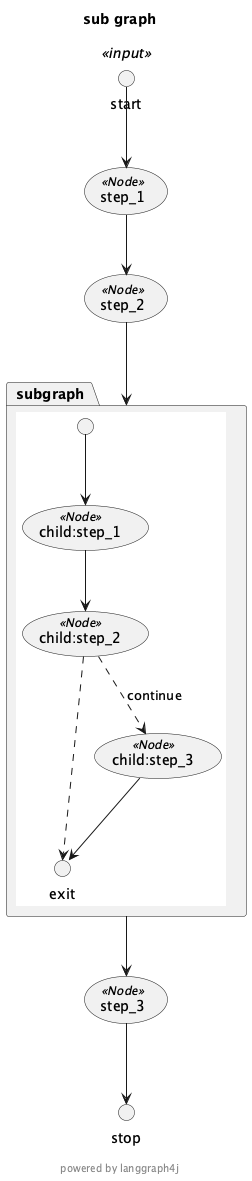

In [9]:
var representation = workflow.getGraph( GraphRepresentation.Type.PLANTUML, "sub graph", false );

displayDiagram( representation );

**Display Compiled Graph** result as merged process

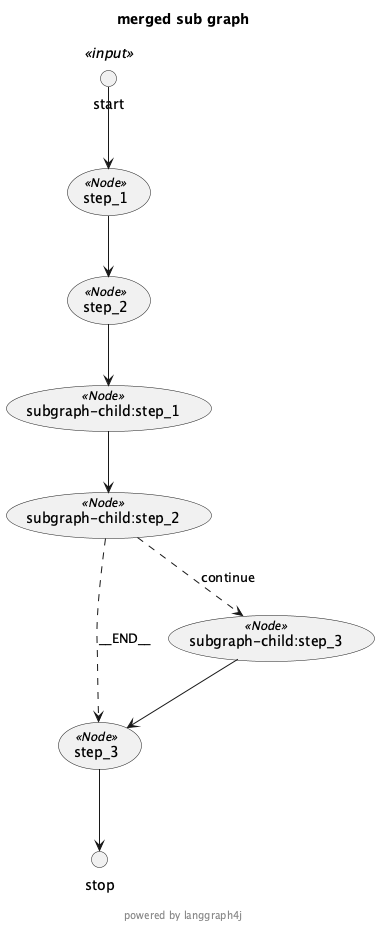

In [10]:
var representation = compiledWorkflow.getGraph( GraphRepresentation.Type.PLANTUML, "merged sub graph", false );

displayDiagram( representation );